## Train Semantic Segmentation Model in SageMaker with Augmented Manifests  

This notebook demonstrates the use of an "augmented manifest" to train a semantic segmentation machine learning model using Amazon SageMaker builtin Semantic Segmentation Algorithm and also perform hyperparameter tuning to get a good performance model.


### Setup
Here we define S3 file path for input and otuput dta, the training image containing the semantic segmentation algorithm, and instantiate a SageMaker session

In [7]:
import sagemaker
from sagemaker import get_execution_role

import sys
import os
import pandas as pd
import numpy as np
import glob
import shutil
import json
from datetime import datetime
import boto3

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import io 

import numpy as np
import json
 
role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()

In [4]:
# example
bucket = sess.default_bucket() 
prefix = 'semantic_segmentation'

In [11]:
training_image = sagemaker.image_uris.retrieve('semantic-segmentation', region)
print(training_image)

sagemaker_client = boto3.client('sagemaker')

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


Note that, the manifest files are the output generated by SageMaker GroundTruth job. No change needed from the GroundTruth job output.

In [12]:
train_mani = 's3://{}/{}/input_manifest/{}'.format(bucket,prefix,'output-train.manifest')
val_mani = 's3://{}/{}/input_manifest/{}'.format(bucket,prefix,'output-validation.manifest')
output_uri = 's3://{}/{}/{}'.format(bucket, prefix, 'output')
print(train_mani)

s3://sagemaker-us-east-1-631450739534/semantic_segmentation/input_manifest/output-train.manifest


Please make sure the train_attribute and validation_attribute are correctly identified in the manifest file. This should be the key of of the corresponding output mask image from the GroundTruth job. For example:

```
{ 
    "source-ref":"s3://blog2data/image17.jpeg",
    "semantic-segmentation-custom-dataset-08112021-ref":"s3://mel-groundtruth-us-east-1/semantic-segmentation-custom-dataset-08112021/annotations/consolidated-annotation/output/9_2021-11-09T05:21:53.668249.png",
    "semantic-segmentation-custom-dataset-08112021-ref-metadata":{"internal-color-map":{"0":{"class-name":"BACKGROUND", 
    ...
}
```

In [13]:
# some hyperparameters that need to be changed to meet your own job requirements
instanceType = 'ml.p3.8xlarge'
nm_classes = "11"
num_training_samples = "43"
validation_mini_batch_size = "5"
mini_batch_size = "5"
epochs = "10"
VolumeSizeInGB = 10
train_attribute = "semantic-segmentation-custom-dataset-08112021-ref"
validation_attribute = "semantic-segmentation-custom-dataset-08112021-ref"

### Create a Training Job

This section demonstrates how to create a semantic segmentation training job using boto3 low-level api. You can choose to use the SageMaker SDK high-level api, please refer to the [official document](https://sagemaker.readthedocs.io/en/stable/api/training/index.html).

In [14]:
timestamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")
training_job_name = 'test-ss-augmanifest-' + timestamp

response = sagemaker_client.create_training_job(
    AlgorithmSpecification={
        'TrainingImage': training_image,
        'TrainingInputMode': 'Pipe'
    },
    RoleArn=role,
    OutputDataConfig={
        'S3OutputPath': output_uri
    },
    ResourceConfig={
        'InstanceType': instanceType,
        'InstanceCount': 1,
        'VolumeSizeInGB': VolumeSizeInGB
    },
    TrainingJobName=training_job_name,
    HyperParameters={
        "weight_decay": "0.0001",
        "num_classes": nm_classes,
        "gamma2": "0.90",
        "gamma1": "0.90",
        "num_training_samples": num_training_samples,
        "early_stopping": "True",
        "early_stopping_patience": "4",
        "crop_size": "240",
        "momentum": "0.99",
        "lr_scheduler": "poly",
        "optimizer": "rmsprop",
        "early_stopping_tolerance": "0.0",
        "use_pretrained_model": "True",
        "backbone": "resnet-50",
        "validation_mini_batch_size": validation_mini_batch_size,
        "epochs": epochs,
        "learning_rate": "0.0001",
        "early_stopping_min_epochs": "5",
        "algorithm": "fcn",
        "mini_batch_size": mini_batch_size
    },
    StoppingCondition={
        "MaxRuntimeInSeconds": 3600
    },
    InputDataConfig=[
        {
            'ChannelName': 'train',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'AugmentedManifestFile',
                    'S3Uri': train_mani,
                    'S3DataDistributionType': 'FullyReplicated',
                    'AttributeNames': [
                        "source-ref",
                        train_attribute
                    ]
                }
            },
            'ContentType': 'application/x-recordio',
            'CompressionType': 'None',
            'RecordWrapperType': 'RecordIO',
            'InputMode': 'Pipe'
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": val_mani,
                    "S3DataDistributionType": "FullyReplicated",
                    'AttributeNames': [
                        "source-ref",
                        validation_attribute
                    ]
                }
            },
            'ContentType': 'application/x-recordio',
            'CompressionType': 'None',
            'RecordWrapperType': 'RecordIO',
            'InputMode': 'Pipe'
        }
    ]
)
print('TrainingJobArn = {}'.format(response['TrainingJobArn']))

response = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
status = response['TrainingJobStatus']
print('TrainingJobStatus  = {}'.format(status))

# wait until the status has changed
sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)

# print the status of the training job
response = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
status = response['TrainingJobStatus']
print('TrainingJob ended with TrainingJobStatus = {}'.format(status))

TrainingJobArn = arn:aws:sagemaker:us-east-1:631450739534:training-job/test-ss-augmanifest-20220411234422
TrainingJobStatus  = InProgress
TrainingJob ended with TrainingJobStatus = Completed


### Create a model and deploy the model to an endpoint for inference

This section shows how to using boto3 api to create a model using the trained model artifacts and also create endpoint configuration. Then we can use these resources to deploy the trained model to an endpoint for real-time inference. You can find how I read in a test.png file and send it via the sagemaker runtime boto3 api to invoke the endpoint.

In [64]:
timestamp = datetime.utcnow().strftime('-%Y-%m-%d-%H-%M-%S')
model_name="test-ss-model-" + timestamp
print(model_name)
info = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
# model_data = "s3://sagemaker-us-east-1-631450739534/smjs-d-mx-semseg-fcn-resnet101-coco-20220412-002211/output/model.tar.gz"
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

test-ss-model--2022-04-12-22-18-47
s3://sagemaker-us-east-1-631450739534/semantic_segmentation/output/test-ss-augmanifest-20220411234422/output/model.tar.gz
arn:aws:sagemaker:us-east-1:631450739534:model/test-ss-model--2022-04-12-22-18-47


In [65]:
timestamp = datetime.utcnow().strftime('-%Y-%m-%d-%H-%M-%S')
endpoint_config_name = 'test-ss-endpointconfig-' + timestamp
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.g4dn.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: test-ss-endpointconfig--2022-04-12-22-18-49
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:631450739534:endpoint-config/test-ss-endpointconfig--2022-04-12-22-18-49


In [71]:
timestamp = datetime.utcnow().strftime('-%Y-%m-%d-%H-%M-%S')
endpoint_name = 'test-ss-endpoint' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker_client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
sagemaker_client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Endpoint name: test-ss-endpoint-2022-04-13-05-16-02
EndpointArn = arn:aws:sagemaker:us-east-1:631450739534:endpoint/test-ss-endpoint-2022-04-13-05-16-02
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


We use one of the test images 'image22.jpeg' to demonstarte the semantic segmentation model output. We first plot the image in this cell.

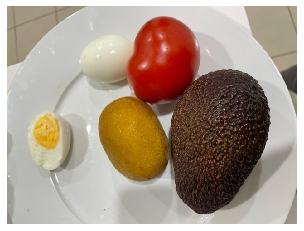

In [67]:

filename = 'image22.jpeg'
im = PIL.Image.open(filename)
%matplotlib inline
plt.imshow(im)
plt.axis('off')
client = boto3.client('sagemaker-runtime')
num_classes = int(nm_classes)

In [72]:
with open(filename, 'rb') as image:
    img = image.read()
    img = bytearray(img)

Now we pass the payload to the endpoint to get the inference result and show the masked image.

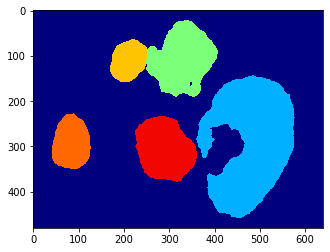

In [73]:
response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='image/png',
    Accept='image/png',
    Body=img
    )
mask = np.array(Image.open(io.BytesIO(response['Body'].read())))
plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
plt.show()

### Automatic Model Tuning

We can see that the first model trained by randomly selecting the hyperparameters doesn't provide a very satisfactory output of the mask. Selecting the right hyperparameter values for machine learning model can be difficult. The right answer dependes on the algorithm and the data; Some algorithms have many tuneable hyperparameters; Some are very sensitive to the hyperparameter values selected; and yet most have a non-linear relationship between model fit and hyperparameter values. Amazon SageMaker Automatic Model Tuning helps by automating the hyperparameter tuning process.

#### Set up hyperparameter tuning job

This section shows a sample code snippet to run hyperparameter jobs using boto3 api. We will run 10 training jobs and one at a time. 


In [79]:
timestamp = datetime.utcnow().strftime("%Y%m%d%H%M%S")
hpo_job_name = 'hpo-test-ss-' + timestamp
response = sagemaker_client.create_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=hpo_job_name,
        HyperParameterTuningJobConfig={
            "Strategy": "Bayesian",
            "ResourceLimits": {
                "MaxNumberOfTrainingJobs": 10,
                "MaxParallelTrainingJobs": 1
            },
        },
        TrainingJobDefinitions=[
            {
                "DefinitionName": "test-ss-hpo",
                "TuningObjective": {
                    "Type": "Maximize",
                    "MetricName": "validation:pixel_accuracy"
                },
                "HyperParameterRanges": {
                    "IntegerParameterRanges": [
                        {
                            "Name": "mini_batch_size",
                            "MinValue": "4",
                            "MaxValue": "6",
                            "ScalingType": "Linear"
                        }
                    ],
                    "ContinuousParameterRanges": [
                        {
                            "Name": "learning_rate",
                            "MinValue": "0.00001",
                            "MaxValue": "0.01",
                            "ScalingType": "Logarithmic"
                        },
                        {
                            "Name": "momentum",
                            "MinValue": "0.9",
                            "MaxValue": "0.99",
                            "ScalingType": "ReverseLogarithmic"
                        },
                        {
                            "Name": "weight_decay",
                            "MinValue": "0.00001",
                            "MaxValue": "0.001",
                            "ScalingType": "Logarithmic"
                        }
                    ],
                    "CategoricalParameterRanges": [
                        {
                            "Name": "optimizer",
                            "Values": [
                                "sgd",
                                "adam",
                                "rmsprop"
                            ]
                        }
                    ]
                },
                "StaticHyperParameters":{
                    "num_classes": nm_classes,
                    "gamma2": "0.90",
                    "gamma1": "0.90",
                    "num_training_samples": num_training_samples,
                    "early_stopping": "False",
                    "early_stopping_patience": "4",
                    "crop_size": "240",
                    "lr_scheduler": "poly",
                    "early_stopping_tolerance": "0.0",
                    "use_pretrained_model": "True",
                    "backbone": "resnet-50",
                    "validation_mini_batch_size": validation_mini_batch_size,
                    "epochs": epochs,
                    "early_stopping_min_epochs": "5",
                    "algorithm": "fcn"
                },
                "AlgorithmSpecification": {
                    "TrainingImage": training_image,
                    "TrainingInputMode": "Pipe"
                },
                "RoleArn": role,    
                "InputDataConfig":[
                {
                    'ChannelName': 'train',
                    'DataSource': {
                        'S3DataSource': {
                            'S3DataType': 'AugmentedManifestFile',
                            'S3Uri': train_mani,
                            'S3DataDistributionType': 'FullyReplicated',
                            'AttributeNames': [
                                "source-ref",
                                train_attribute
                            ]
                        }
                    },
                    'ContentType': 'application/x-recordio',
                    'CompressionType': 'None',
                    'RecordWrapperType': 'RecordIO',
                    'InputMode': 'Pipe'
                },
                {
                    "ChannelName": "validation",
                    "DataSource": {
                        "S3DataSource": {
                            "S3DataType": "AugmentedManifestFile",
                            "S3Uri": val_mani,
                            "S3DataDistributionType": "FullyReplicated",
                            'AttributeNames': [
                                "source-ref",
                                validation_attribute
                            ]
                        }
                    },
                    'ContentType': 'application/x-recordio',
                    'CompressionType': 'None',
                    'RecordWrapperType': 'RecordIO',
                    'InputMode': 'Pipe'
                }
                ],
             "OutputDataConfig": {
                    "KmsKeyId": "",
                    "S3OutputPath": output_uri
             },
             "ResourceConfig": {
                    "InstanceType": instanceType,
                    "InstanceCount": 1,
                    "VolumeSizeInGB": VolumeSizeInGB,
                    "VolumeKmsKeyId": ""
             },
             "StoppingCondition": {
                    "MaxRuntimeInSeconds": 3600
             },
             "EnableNetworkIsolation": False,
             "EnableInterContainerTrafficEncryption": False,
             "EnableManagedSpotTraining": False
        }
    ]
)
print('HPOJobArn = {}'.format(response['HyperParameterTuningJobArn']))
response = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=hpo_job_name)
status = response['HyperParameterTuningJobStatus']
print('HyperParameterTuningJobStatus  = {}'.format(status))

HPOJobArn = arn:aws:sagemaker:us-east-1:631450739534:hyper-parameter-tuning-job/hpo-test-ss-20220413054302
HyperParameterTuningJobStatus  = InProgress


In [81]:
# You can check the HPO job status using the below code
response = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=hpo_job_name)
status = response['HyperParameterTuningJobStatus']
print('HyperParameterTuningJobStatus  = {}'.format(status))

HyperParameterTuningJobStatus  = Completed


Once the hyperparameter tuning job finishes. We will get the best training job and the model data uri of that job.

In [82]:
# get the best training job
best_training_job_name = response['BestTrainingJob']['TrainingJobName']
print(best_training_job_name)

timestamp = datetime.utcnow().strftime('-%Y-%m-%d-%H-%M-%S')
model_name="best-job-test-ss-" + timestamp
print(model_name)
info = sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hpo-test-ss-20220413054302-008-903aedca
best-job-test-ss--2022-04-13-07-03-32
s3://sagemaker-us-east-1-631450739534/semantic_segmentation/output/hpo-test-ss-20220413054302-008-903aedca/output/model.tar.gz



### Model deployment and inference
This time we demonstrate how to use SageMaker python sdk to create a model from the trained model artefacts and deploy to an endpoint. Also use the predictor object to perform inference.

In [84]:
from sagemaker.model import Model

model = Model(
    image_uri = training_image,
    model_data = model_data,
    name = model_name,
    role = role,
    sagemaker_session = sess
)

In [95]:
endpoint_name = "best_ss_model_" + datetime.utcnow().strftime('%d-%H-%M-%S')
model.deploy(initial_instance_count=1, 
            instance_type='ml.m5.2xlarge',
            sagemaker_session=sess,
            endpoint_name=endpoint_name,
                            )

Using already existing model: best-job-test-ss--2022-04-13-07-03-32


-------!

In [88]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()
            


In [100]:
ss_predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name, 
                                             sagemaker_session=sess)

In [134]:
ss_predictor.deserializer = ImageDeserializer(accept="image/png")
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

filename0 = './test_before.jpeg'  
filename1 = './test_after.jpeg'

In [223]:
def prediction_fn(ss_predictor, filename):
    with open(filename, "rb") as imfile:
        img = imfile.read()
    cls_mask = ss_predictor.predict(img)

    plt.imshow(cls_mask, vmin=0, vmax=num_classes-1, cmap="jet")
    plt.show()
    return cls_mask

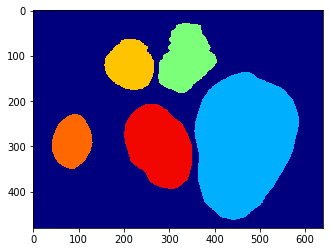

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [224]:
filename = 'image22.jpeg'
prediction_fn(ss_predictor, filename)

(-0.5, 639.5, 479.5, -0.5)

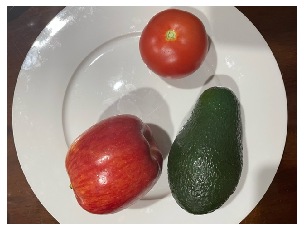

In [135]:
plt.imshow(PIL.Image.open(filename0))
plt.axis('off')

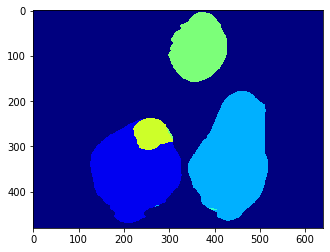

In [225]:
cls_mask0 = prediction_fn(ss_predictor, filename0)

(-0.5, 639.5, 479.5, -0.5)

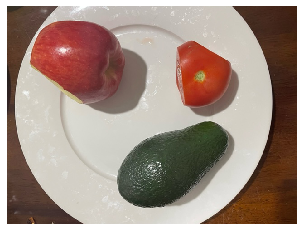

In [137]:
plt.imshow(PIL.Image.open(filename1))
plt.axis('off')

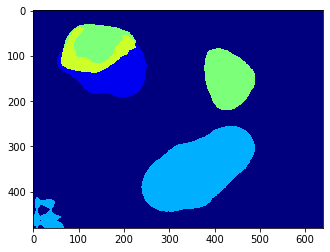

In [226]:
cls_mask1 = prediction_fn(ss_predictor, filename1)

In [171]:
json_str = open('class_label_to_prediction_index.json')
label = dict([(value, key) for key, value in json.loads(json_str.read()).items()])
label

{0: 'BACKGROUND',
 1: 'apple',
 2: 'half-apple',
 3: 'avocado',
 4: 'half-avocado',
 5: 'tomato',
 6: 'half-tomato',
 7: 'egg',
 8: 'half-egg',
 9: 'kiwi',
 10: 'half-kiwi'}

In [230]:
def plot_pie_chart(cls_mask, label, threshold=50):
    area = np.unique(cls_mask[cls_mask>0], return_counts = True)
    index = area[1]>threshold
    labels = area[0][index]
    pixels = area[1][index]
    plt.pie(pixels, labels = [label[i] for i in labels])
    plt.legend()
    plt.show() 

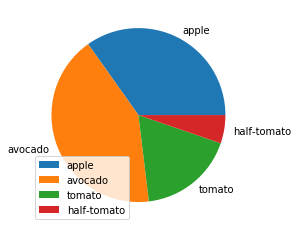

In [231]:
plot_pie_chart(cls_mask0, label)

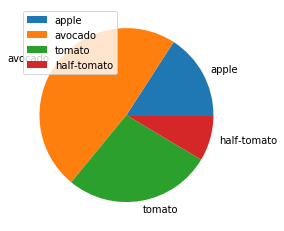

In [232]:
plot_pie_chart(cls_mask1, label)

In [233]:
def plot_pie_chart_diff(cls_mask0, cls_mask1, label, threshold=100):
    '''
        Ploting the pie chart of the elements that has been consumed
    '''
    area0 = np.unique(cls_mask0[cls_mask0>0], return_counts = True)
    area1 = np.unique(cls_mask1[cls_mask1>0], return_counts = True)
    before = dict([i for i in zip(area0[0], area0[1])])
    after = dict([i for i in zip(area1[0], area1[1])])
    area_diff = {k: before[k] - after[k] for k in before.keys() & after.keys()}
    area_values = np.array(list(area_diff.values()))
    list_label = np.array(list(area_diff.keys()))
    plt.pie(area_values[area_values>0], labels = [label[i] for i in list_label[area_values>0]])
    plt.legend()
    plt.show() 

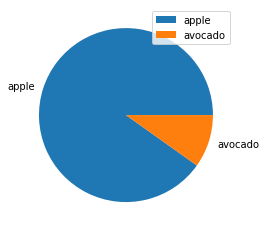

In [234]:
plot_pie_chart_diff(cls_mask0, cls_mask1, label)